In [16]:
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import matplotlib.pyplot as pl
from scipy.spatial.distance import cdist
from numpy.linalg import inv
import george

# Gaussian process regression 

## Lecture 1

### Suzanne Aigrain, University of Oxford

#### LSST DSFP Session 4, Seattle, Sept 2017

- Lecture 1: Introduction and basics

     - Tutorial 1: Write your own GP code

- Lecture 2: Examples and practical considerations

    - Tutorial 3: Useful GP modules

- Lecture 3: Advanced applications

## Why GPs?

- flexible, robust probabilistic regression and classification tools. 

- applied across a wide range of fields, from finance to zoology. 

- useful for data containing non-trivial stochastic signals or noise.

- time-series data: causation implies correlation, so noise always correlated.

- increasingly popular in astronomy [mainly time-domain, but not just].

#### Spitzer exoplanet transits and eclipses (Evans et al. 2015)

<img src="images/Evans_Spitzer.png" width="800">

#### GPz photometric redshifts (Almosallam, Jarvis & Roberts 2016)

<img src="images/Almosallam_GPz.png" width="600">

## What is a GP?

A Gaussian process is a collection of random variables, any 
finite number of which have a joint Gaussian distribution.

Consider a scalar variable $y$, drawn from a Gaussian distribution with mean $\mu$ and variance $\sigma^2$:

$$
p(y) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left[ - \frac{(y-\mu)^2}{2 \sigma^2} \right].
$$

As a short hand, we write: $y \sim \mathcal{N}(\mu,\sigma^2)$.

In [17]:
def gauss1d(x,mu,sig):
    return np.exp(-(x-mu)**2/sig*2/2.)/np.sqrt(2*np.pi)/sig
def pltgauss1d(sig=1):
    mu=0
    x = np.r_[-4:4:101j]
    pl.figure(figsize=(10,7))
    pl.plot(x, gauss1d(x,mu,sig),'k-');
    pl.axvline(mu,c='k',ls='-');
    pl.axvline(mu+sig,c='k',ls='--');
    pl.axvline(mu-sig,c='k',ls='--');
    pl.axvline(mu+2*sig,c='k',ls=':');
    pl.axvline(mu-2*sig,c='k',ls=':');
    pl.xlim(x.min(),x.max());
    pl.ylim(0,1);
    pl.xlabel(r'$y$');
    pl.ylabel(r'$p(y)$');
    return
interact(pltgauss1d,
         sig=widgets.FloatSlider(value=1.0,
                                 min=0.5,
                                 max=2.0,
                                 step=0.25,
                                 description=r'$\sigma$',
                                 readout_format='.2f'));

A Jupyter Widget

Now let us consider a pair of variables $y_1$ and $y_2$, drawn from a *bivariate Gaussian distribution*. The *joint probability density* for $y_1$ and $y_2$ is:

$$
\left[ \begin{array}{l} y_1 \\ y_2 \end{array} \right] \sim \mathcal{N} \left(
\left[ \begin{array}{l} \mu_1 \\ \mu_2 \end{array}  \right] , 
\left[ \begin{array}{ll} 
\sigma_1^2 & C \\
C & \sigma_2^2 
\end{array}  \right] 
\right),
$$

where $C = {\rm cov}(y_1,y_2)$ is the *covariance* between $y_1$ and $y_2$.
The second term on the right hand side is the *covariance matrix*, $K$.

We now use two powerful *identities* of Gaussian distributions to elucidate the relationship between $y_1$ and $y_2$. 

The *marginal distribution* of $y_1$ describes what we know about $y_1$ in the absence of any other information about $y_2$, and is simply:

$$
p(y_1)= \mathcal{N} (\mu_1,\sigma_1^2).
$$

If we know the value of $y_2$, the probability density for $y_1$ collapses to the the *conditional distribution* of $y_1$ given $y_2$:

$$
p(y_1 \mid y_2) = \mathcal{N} \left( \mu_1 + C (y_2-\mu_2)/\sigma_2^2, \sigma_1^2-C^2\sigma_2^2 \right).
$$

If $K$ is diagonal, i.e. if $C=0$, $p(y_1 \mid y_2) = p(y_1)$. Measuring $y_2$ doesn't teach us anything about $y_1$. The two variables are *uncorrelated*. 

If the variables are *correlated* ($C \neq 0$), measuring $y_2$ does alter our knowledge of $y_1$: it modifies the mean and reduces the variance.

In [18]:
def gauss2d(x1,x2,mu1,mu2,sig1,sig2,rho):
    z = (x1-mu1)**2/sig1**2 + (x2-mu2)**2/sig2**2 - 2*rho*(x1-mu1)*(x2-mu2)/sig1/sig2    
    e = np.exp(-z/2/(1-rho**2))
    return e/(2*np.pi*sig1*sig2*np.sqrt(1-rho**2))
def pltgauss2d(rho=0,show_cond=0):
    mu1, sig1 = 0,1
    mu2, sig2 = 0,1
    y2o = -1
    x1 = np.r_[-4:4:101j]
    x2 = np.r_[-4:4:101j]
    x22d,x12d = np.mgrid[-4:4:101j,-4:4:101j]
    y = gauss2d(x12d,x22d,mu1,mu2,sig1,sig2,rho)
    y1 = gauss1d(x1,mu1,sig1)
    y2 = gauss1d(x2,mu2,sig2)
    mu12 = mu1+rho*(y2o-mu2)/sig2**2
    sig12 = np.sqrt(sig1**2-rho**2*sig2**2)
    y12 = gauss1d(x1,mu12,sig12)
    pl.figure(figsize=(10,10))
    ax1 = pl.subplot2grid((3,3),(1,0),colspan=2,rowspan=2,aspect='equal')
    v = np.array([0.02,0.1,0.3,0.6]) * y.max()
    CS = pl.contour(x1,x2,y,v,colors='k')
    if show_cond: pl.axhline(y2o,c='r')
    pl.xlabel(r'$y_1$');
    pl.ylabel(r'$y_2$');
    pl.xlim(x1.min(),x1.max())
    ax1.xaxis.set_major_locator(pl.MaxNLocator(5, prune = 'both'))
    ax1.yaxis.set_major_locator(pl.MaxNLocator(5, prune = 'both'))
    ax2 = pl.subplot2grid((3,3),(0,0),colspan=2,sharex=ax1)
    pl.plot(x1,y1,'k-')
    if show_cond: pl.plot(x1,y12,'r-')
    pl.ylim(0,0.8)
    pl.ylabel(r'$p(y_1)$')
    pl.setp(ax2.get_xticklabels(), visible=False)
    ax2.xaxis.set_major_locator(pl.MaxNLocator(5, prune = 'both'))
    ax2.yaxis.set_major_locator(pl.MaxNLocator(4, prune = 'upper'))
    pl.xlim(x1.min(),x1.max())
    ax3 = pl.subplot2grid((3,3),(1,2),rowspan=2,sharey=ax1)
    pl.plot(y2,x2,'k-')
    if show_cond: pl.axhline(y2o,c='r')
    pl.ylim(x2.min(),x2.max());
    pl.xlim(0,0.8);
    pl.xlabel(r'$p(y_2)$')
    pl.setp(ax3.get_yticklabels(), visible=False)
    ax3.xaxis.set_major_locator(pl.MaxNLocator(4, prune = 'upper'))
    ax3.yaxis.set_major_locator(pl.MaxNLocator(5, prune = 'both'))
    pl.subplots_adjust(hspace=0,wspace=0)
    return 
interact(pltgauss2d, 
         rho=widgets.FloatSlider(min=-0.8,max=0.8,step=0.4,description=r'$\rho$',value=0),
         show_cond=widgets.Checkbox(value=True,description='show conditional distribution'));

A Jupyter Widget

To make the relation to time-series data a bit more obvious, let's plot the two variables side by side, then see what happens to one variable when we observe (fix) the other.

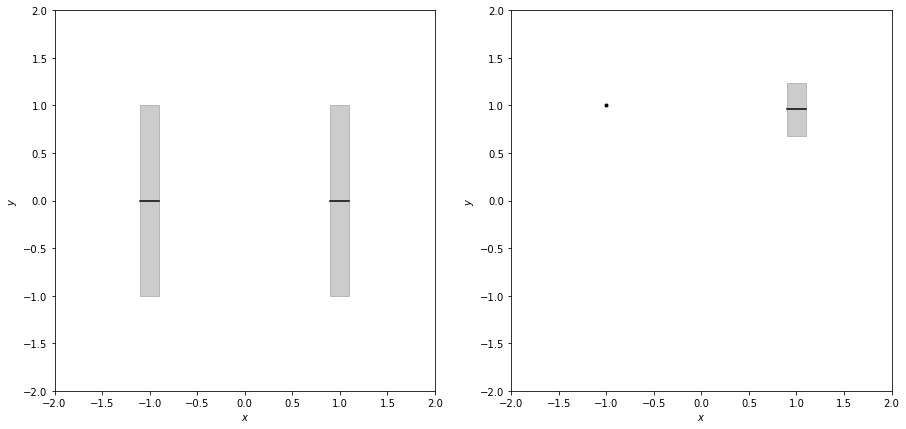

In [19]:
def SEKernel(par, x1, x2):
    A, Gamma = par
    D2 = cdist(x1.reshape(len(x1),1), x2.reshape(len(x2),1), 
               metric = 'sqeuclidean')
    return A * np.exp(-Gamma*D2)
A = 1.0
Gamma = 0.01
x = np.array([-1,1])
K = SEKernel([A,Gamma],x,x)
m = np.zeros(len(x))
sig = np.sqrt(np.diag(K))
pl.figure(figsize=(15,7))
pl.subplot(121)
for i in range(len(x)):
    pl.plot([x[i]-0.1,x[i]+0.1],[m[i],m[i]],'k-')
    pl.fill_between([x[i]-0.1,x[i]+0.1],
                    [m[i]+sig[i],m[i]+sig[i]],
                    [m[i]-sig[i],m[i]-sig[i]],color='k',alpha=0.2)
pl.xlim(-2,2)
pl.ylim(-2,2)
pl.xlabel(r'$x$')
pl.ylabel(r'$y$');

def Pred_GP(CovFunc, CovPar, xobs, yobs, eobs, xtest):
    # evaluate the covariance matrix for pairs of observed inputs
    K = CovFunc(CovPar, xobs, xobs) 
    # add white noise
    K += np.identity(xobs.shape[0]) * eobs**2
    # evaluate the covariance matrix for pairs of test inputs
    Kss = CovFunc(CovPar, xtest, xtest)
    # evaluate the cross-term
    Ks = CovFunc(CovPar, xtest, xobs)
    # invert K
    Ki = inv(K)
    # evaluate the predictive mean
    m = np.dot(Ks, np.dot(Ki, yobs))
    # evaluate the covariance
    cov = Kss - np.dot(Ks, np.dot(Ki, Ks.T))
    return m, cov
xobs = np.array([-1])
yobs = np.array([1.0])
eobs = 0.0001
pl.subplot(122)
pl.errorbar(xobs,yobs,yerr=eobs,capsize=0,fmt='k.')
x = np.array([1])
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))
for i in range(len(x)):
    pl.plot([x[i]-0.1,x[i]+0.1],[m[i],m[i]],'k-')
    pl.fill_between([x[i]-0.1,x[i]+0.1],
                    [m[i]+sig[i],m[i]+sig[i]],
                    [m[i]-sig[i],m[i]-sig[i]],color='k',alpha=0.2)
pl.xlim(-2,2)
pl.ylim(-2,2)
pl.xlabel(r'$x$')
pl.ylabel(r'$y$');

Now consider $N$ variables drawn from a multivariate Gaussian distribution:

$$
\boldsymbol{y} \sim \mathcal{N} (\boldsymbol{m},K)
$$

where $y = (y_1,y_2,\ldots,y_N)^T$, $\boldsymbol{m} = (m_1,m_2,\ldots,m_N)^T$ is the *mean vector*, and $K$ is an $N \times N$ positive semi-definite *covariance matrix*, with elements $K_{ij}={\rm cov}(y_i,y_j)$. 

A Gaussian process is an extension of this concept to infinite $N$, giving rise to a probability distribution over functions. 

This last generalisation may not be obvious conceptually, but in practice only ever deal with finite samples.

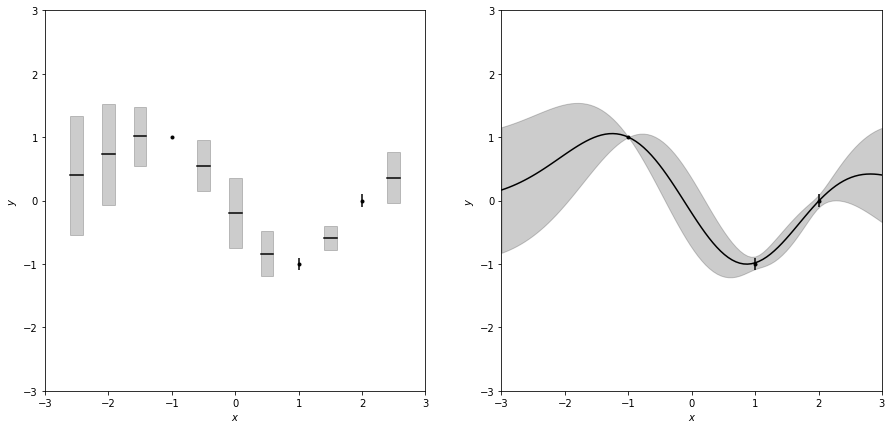

In [20]:
xobs = np.array([-1,1,2])
yobs = np.array([1,-1,0])
eobs = np.array([0.0001,0.1,0.1])
pl.figure(figsize=(15,7))
pl.subplot(121)
pl.errorbar(xobs,yobs,yerr=eobs,capsize=0,fmt='k.')
Gamma = 0.5
x = np.array([-2.5,-2,-1.5,-0.5, 0.0, 0.5,1.5,2.5])
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))
for i in range(len(x)):
    pl.plot([x[i]-0.1,x[i]+0.1],[m[i],m[i]],'k-')
    pl.fill_between([x[i]-0.1,x[i]+0.1],
                    [m[i]+sig[i],m[i]+sig[i]],
                    [m[i]-sig[i],m[i]-sig[i]],color='k',alpha=0.2)
pl.xlim(-3,3)
pl.ylim(-3,3)
pl.xlabel(r'$x$')
pl.ylabel(r'$y$');

pl.subplot(122)
pl.errorbar(xobs,yobs,yerr=eobs,capsize=0,fmt='k.')
x = np.linspace(-3,3,100)
m,C=Pred_GP(SEKernel,[A,Gamma],xobs,yobs,eobs,x)
sig = np.sqrt(np.diag(C))
pl.plot(x,m,'k-')
pl.fill_between(x,m+sig,m-sig,color='k',alpha=0.2)
pl.xlim(-3,3)
pl.ylim(-3,3)
pl.xlabel(r'$x$')
pl.ylabel(r'$y$');

## Textbooks

A good, detailed reference is [*Gaussian Processes for Machine Learning*](http://www.gaussianprocess.org/gpml/) by C. E. Rasmussen & C. Williams, MIT Press, 2006.

The examples in the book are generated using the `Matlab` package `GPML`.

## A more formal definition

A Gaussian process is completely specified by its *mean function* and *covariance function*. 

We define the mean function $m(x)$ and the covariance function $k(x,x)$ of a real process $y(x)$ as
$$
\begin{array}{rcl}
m(x) & = & \mathbb{E}[y(x)], \\
k(x,x') & = & \mathrm{cov}(y(x),y(x'))=\mathbb{E}[(y(x) − m(x))(y(x') − m(x'))].
\end{array}
$$

A very common covariance function is the squared exponential, or radial basis function (RBF) kernel
$$
K_{ij}=k(x_i,x_j)=A \exp\left[ - \Gamma (x_i-x_j)^2 \right],
$$
which has 2 parameters: $A$ and $\Gamma$.

We then write the Gaussian process as
$$
y(x) \sim \mathcal{GP}(m(x), k(x,x'))
$$

Here we are implicitly assuming the inputs $x$ are one-dimensional, e.g. $x$ might represent time. However, the input space can have more than one dimension. We will see an example of a GP with multi-dimensional inputs later.

## The prior

Now consider a finite set of inputs $\boldsymbol{x}$, with corresponding outputs $\boldsymbol{y}$. 

The *joint distribution* of $\boldsymbol{y}$ given $\boldsymbol{x}$, $m$ and $k$ is
$$
\mathrm{p}(\boldsymbol{y} \mid \boldsymbol{x},m,k) = \mathcal{N}( \boldsymbol{m},K),
$$

where $\boldsymbol{m}=m(\boldsymbol{x})$ is the *mean vector*,

and $K$ is the *covariance matrix*, with elements $K_{ij} = k(x_i,x_j)$.

## Test and training sets

Suppose we have an (observed) *training set* $(\boldsymbol{x},\boldsymbol{y})$. 

We are interested in some other *test set* of inputs $\boldsymbol{x}_*$.

The joint distribution over the training and test sets is
$$
\mathrm{p} \left( \left[ \begin{array}{l} \boldsymbol{y} \\ \boldsymbol{y}_* \end{array} \right] \right) 
= \mathcal{N} \left( \left[ \begin{array}{l} \boldsymbol{m} \\ \boldsymbol{m}_* \end{array} \right], 
\left[ \begin{array}{ll} K & K_* \\ K_*^T & K_{**} \end{array} \right] \right),
$$

where $\boldsymbol{m}_* = m(\boldsymbol{x}_*)$, $K_{**,ij} = k(x_{*,i},x_{*,j})$ and $K_{*,ij} = k(x_i,x_{*,j})$. 

For simplicity, assume the mean function is zero everywhere: $\boldsymbol{m}=\boldsymbol{0}$. We will consider to non-trivial mean functions later.

## The conditional distribution

The *conditional distribution* for the test set given the training set is:
$$ 
\mathrm{p} ( \boldsymbol{y}_* \mid \boldsymbol{y},k) = \mathcal{N} ( 
K_*^T K^{-1} \boldsymbol{y}, K_{**} - K_*^T K^{-1} K_* ).
$$

This is also known as the *predictive distribution*, because it can be use to predict future (or past) observations. 

More generally, it can be used for *interpolating* the observations to any desired set of inputs. 

This is one of the most widespread applications of GPs in some fields (e.g. kriging in geology, economic forecasting, ...)

## Adding white noise

Real observations always contain a component of *white noise*, which we need to account for, but don't necessarily want to include in the predictions. 

If the white noise variance $\sigma^2$ is constant, we can write 
$$
\mathrm{cov}(y_i,y_j)=k(x_i,x_j)+\delta_{ij} \sigma^2,
$$

and the conditional distribution becomes
$$ 
\mathrm{p} ( \boldsymbol{y}_* \mid \boldsymbol{y},k) = \mathcal{N} ( 
K_*^T (K + \sigma^2 \mathbb{I})^{-1} \boldsymbol{y}, K_{**} - K_*^T (K + \sigma^2 \mathbb{I})^{-1} K_* ).
$$

In real life, we may need to learn $\sigma$ from the data, alongside the other contribution to the covariance matrix.

We assumed constant white noise, but it's trivial to allow for different $\sigma$ for each data point.

## Single-point prediction

Let us look more closely at the predictive distribution for a single test point $x_*$.

It is a Gaussian with mean
$$
\overline{y}_* = \boldsymbol{k}_*^T (K + \sigma^2 \mathbb{I})^{-1} \boldsymbol{y}
$$
and variance
$$
\mathbb{V}[y_*] = k(x_*,x_*) - \boldsymbol{k}_*^T (K + \sigma^2 \mathbb{I})^{-1} \boldsymbol{k}_*,
$$
where $\boldsymbol{k}_*$ is the vector of covariances between the test point and the training points.

Notice the mean is a linear combination of the observations: the GP is a *linear predictor*.

It is also a linear combination of covariance functions, each centred on a training point:
$$
\overline{y}_* = \sum_{i=1}^N \alpha_i k(x_i,x_*),
$$
where $\alpha_i = (K + \sigma^2 \mathbb{I})^{-1} y_i$.

## The likelihood

The *likelihood* of the data under the GP model is simply:
$$
\mathrm{p}(\boldsymbol{y} \,|\, \boldsymbol{x}) = \mathcal{N}(\boldsymbol{y} \, | \, \boldsymbol{0},K + \sigma^2 \mathbb{I}).
$$

This is a measure of how well the model explains, or predicts, the training set.

In some textbooks this is referred to as the *marginal likelihood*. 

This arises if one considers the observed $\boldsymbol{y}$ as noisy realisations of a latent (unobserved) Gaussian process $\boldsymbol{f}$.

The term *marginal* refers to marginalisation over the function values $\boldsymbol{f}$:
$$
\mathrm{p}(\boldsymbol{y} \,|\, \boldsymbol{x}) = \int \mathrm{p}(\boldsymbol{y} \,|\, \boldsymbol{f},\boldsymbol{x}) \, \mathrm{p}(\boldsymbol{f} \,|\, \boldsymbol{x}) \, \mathrm{d}\boldsymbol{f},
$$
where 
$$
\mathrm{p}(\boldsymbol{f} \,|\, \boldsymbol{x}) = \mathcal{N}(\boldsymbol{f} \, | \, \boldsymbol{0},K)
$$
is the *prior*, and 
$$
\mathrm{p}(\boldsymbol{y} \,|\, \boldsymbol{f},\boldsymbol{x}) = \mathcal{N}(\boldsymbol{y} \, | \, \boldsymbol{0},\sigma^2 \mathbb{I})
$$
is the *likelihood*.

## Parameters and hyper-parameters 

The parameters of the covariance and mean function as known as the *hyper-parameters* of the GP. 

This is because the actual *parameters* of the model are the function values, $\boldsymbol{f}$, but we never explicitly deal with them: they are always marginalised over.

## *Conditioning* the GP...

...means evaluating the conditional (or predictive) distribution for a given covariance matrix (i.e. covariance function and hyper-parameters), and training set.

## *Training* the GP...

...means maximising the *likelihood* of the model with respect to the hyper-parameters.

## The kernel trick

Consider a linear basis model with arbitrarily many *basis functions*, or *features*, $\Phi(x)$, and a (Gaussian) prior $\Sigma_{\mathrm{p}}$ over the basis function weights. 

One ends up with exactly the same expressions for the predictive distribution and the likelihood so long as:
$$
k(\boldsymbol{x},\boldsymbol{x'}) = \Phi(\boldsymbol{x})^{\mathrm{T}} \Sigma_{\mathrm{p}} \Phi(\boldsymbol{x'}),
$$
or, writing $\Psi(\boldsymbol{x}) = \Sigma_{\mathrm{p}}^{1/2} \Phi(\boldsymbol{x})$,
$$
k(\boldsymbol{x},\boldsymbol{x'}) = \Psi(\boldsymbol{x}) \cdot \Psi(\boldsymbol{x'}),
$$

Thus the covariance function $k$ enables us to go from a (finite) *input space* to a (potentially infinite) *feature space*. This is known as the *kernel trick* and the covariance function is often referred to as the *kernel*.

## Non-zero mean functions

In general (and in astronomy applications in particular) we often want to use non-trivial mean functions.

To do this simply replace $\boldsymbol{y}$ by $\boldsymbol{r}=\boldsymbol{y}-\boldsymbol{m}$ in the expressions for predictive distribution and likelihood.

The mean function represents the *deterministic* component of the model
- e.g.: a linear trend, a Keplerian orbit, a planetary transit, ...

The covariance function encodes the *stochastic* component. 
- e.g.: instrumental noise, stellar variability

## Covariance functions

The only requirement for the covariance function is that it should return a positive semi-definite covariance matrix.

The simplest covariance functions have two parameters: one input and one output variance (or scale). The form of the covariance function controls the degree of smoothness.

### The squared exponential

The simplest, most widely used kernel is the squared exponential:
$$
k_{\rm SE}(x,x') = A \exp \left[ - \Gamma (x-x')^2 \right].
$$
This gives rise to *smooth* functions with variance $A$ and inverse scale (characteristic length scale) $A$ and output scale (amplitude) $l$.

In [21]:
def kernel_SE(X1,X2,par):
    p0 = 10.0**par[0]
    p1 = 10.0**par[1]
    D2 = cdist(X1,X2,'sqeuclidean')
    K = p0 * np.exp(- p1 * D2)
    return np.matrix(K)
def kernel_Mat32(X1,X2,par):
    p0 = 10.0**par[0]
    p1 = 10.0**par[1]
    DD = cdist(X1, X2, 'euclidean')
    arg = np.sqrt(3) * abs(DD) / p1
    K = p0 * (1 + arg) * np.exp(- arg)
    return np.matrix(K)
def kernel_RQ(X1,X2,par):
    p0 = 10.0**par[0]
    p1 = 10.0**par[1]
    alpha = par[2]
    D2 = cdist(X1, X2, 'sqeuclidean')
    K = p0 * (1 + D2 / (2*alpha*p1))**(-alpha)
    return np.matrix(K)
def kernel_Per(X1,X2,par):
    p0 = 10.0**par[0]
    p1 = 10.0**par[1]
    period = par[2]
    DD = cdist(X1, X2, 'euclidean')
    K = p0 * np.exp(- p1*(np.sin(np.pi * DD / period))**2) 
    return np.matrix(K)
def kernel_QP(X1,X2,par):
    p0 = 10.0**par[0]
    p1 = 10.0**par[1]
    period = par[2]
    p3 = 10.0**par[3]
    DD = cdist(X1, X2, 'euclidean')
    D2 = cdist(X1, X2, 'sqeuclidean')
    K = p0 * np.exp(- p1*(np.sin(np.pi * DD / period))**2 - p3 * D2)
    return np.matrix(K)
def add_wn(K,lsig):
    sigma=10.0**lsig
    N = K.shape[0]
    return K + sigma**2 * np.identity(N)
def get_kernel(name):
    if name == 'SE': return kernel_SE
    elif name == 'RQ': return kernel_RQ
    elif name == 'M32': return kernel_Mat32
    elif name == 'Per': return kernel_Per
    elif name == 'QP': return kernel_QP
    else: 
        print 'No kernel called %s - using SE' % name
        return kernel_SE

In [22]:
def pltsamples1(par0=0.0, par1=0.0, wn = 0.0):
    x = np.r_[-5:5:201j]
    X = np.matrix([x]).T # scipy.spatial.distance expects matrices
    kernel = get_kernel('SE')
    K = kernel(X,X,[par0,par1])
    K = add_wn(K,wn)
    fig=pl.figure(figsize=(10,4))
    ax1 = pl.subplot2grid((1,3), (0, 0), aspect='equal')
    pl.imshow(np.sqrt(K),interpolation='nearest',vmin=0,vmax=10)
    pl.title('Covariance matrix')
    ax2 = pl.subplot2grid((1,3), (0,1),colspan=2)
    np.random.seed(0)
    for i in range(3):
        y = np.random.multivariate_normal(np.zeros(len(x)),K)
        pl.plot(x,y-i*2)
    pl.xlim(-5,5)
    pl.ylim(-8,5)
    pl.xlabel('x')
    pl.ylabel('y')
    pl.title('Samples from %s prior' % 'SE')
    pl.tight_layout()

interact(pltsamples1, 
         par0=widgets.FloatSlider(min=-1,max=1,step=0.5,description=r'$\log_{10} A$',value=0),
         par1=widgets.FloatSlider(min=-1,max=1,step=0.5,description=r'$\log_{10} \Gamma$',value=0),
         wn=widgets.FloatSlider(min=-2,max=0,step=1,description=r'$\log_{10} \sigma$',value=-2)
        );

A Jupyter Widget

### The Matern family

The Matern 3/2 kernel
$$
k_{3/2}(x,x')= A \left( 1 + \frac{\sqrt{3}r}{l} \right) \exp \left( - \frac{\sqrt{3}r}{l} \right),
$$
where $r =|x-x'|$.

It produces somewhat rougher behaviour, because it is only differentiable once w.r.t. $r$ (whereas the SE kernel is infinitely differentiable). There is a whole family of Matern kernels with varying degrees of roughness.

## The rational quadratic kernel 

is equivalent to a squared exponential with a powerlaw distribution of input scales
$$
k_{\rm RQ}(x,x') = A^2 \left(1 + \frac{r^2}{2 \alpha l} \right)^{-\alpha},
$$
where $\alpha$ is the index of the power law. 

This is useful to model data containing variations on a range of timescales with just one extra parameter.

In [23]:
# Function to plot samples from kernel
def pltsamples2(par2=0.5, kernel_shortname='SE'):
    x = np.r_[-5:5:201j]
    X = np.matrix([x]).T # scipy.spatial.distance expects matrices
    kernel = get_kernel(kernel_shortname)
    K = kernel(X,X,[0.0,0.0,par2])
    fig=pl.figure(figsize=(10,4))
    ax1 = pl.subplot2grid((1,3), (0, 0), aspect='equal')
    pl.imshow(np.sqrt(K),interpolation='nearest',vmin=0,vmax=10)
    pl.title('Covariance matrix')
    ax2 = pl.subplot2grid((1,3), (0,1),colspan=2)
    np.random.seed(0)
    for i in range(3):
        y = np.random.multivariate_normal(np.zeros(len(x)),K)
        pl.plot(x,y-i*2)
    pl.xlim(-5,5)
    pl.ylim(-8,5)
    pl.xlabel('x')
    pl.ylabel('y')
    pl.title('Samples from %s prior' % kernel_shortname)
    pl.tight_layout()
interact(pltsamples2, 
         par2=widgets.FloatSlider(min=0.25,max=1,step=0.25,description=r'$\alpha$',value=0.5),
         kernel_shortname=widgets.RadioButtons(options=['SE','M32','RQ'], value='SE',description='kernel')
        );

A Jupyter Widget

## Periodic kernels...

...can be constructed by replacing $r$ in any of the above by a periodic function of $r$. For example, the cosine kernel:
$$
k_{\cos}(x,x') = A \cos\left(\frac{2\pi r}{P}\right),
$$
[which follows the dynamics of a simple harmonic oscillator], or...

...the "exponential sine squared" kernel, obtained by mapping the 1-D variable $x$ to the 2-D variable $\mathbf{u}(x)=(\cos(x),\sin(x))$, and then applying a squared exponential in $\boldsymbol{u}$-space:
$$
k_{\sin^2 {\rm SE}}(x,x') = A \exp \left[ -\Gamma \sin^2\left(\frac{\pi r}{P}\right) \right],
$$
which allows for non-harmonic functions.

In [24]:
# Function to plot samples from kernel
def pltsamples3(par2=2.0, par3=2.0,kernel_shortname='Per'):
    x = np.r_[-5:5:201j]
    X = np.matrix([x]).T # scipy.spatial.distance expects matrices
    kernel = get_kernel(kernel_shortname)
    K = kernel(X,X,[0.0,0.0,par2,par3])
    fig=pl.figure(figsize=(10,4))
    ax1 = pl.subplot2grid((1,3), (0, 0), aspect='equal')
    pl.imshow(np.sqrt(K),interpolation='nearest',vmin=0,vmax=10)
    pl.title('Covariance matrix')
    ax2 = pl.subplot2grid((1,3), (0,1),colspan=2)
    np.random.seed(0)
    for i in range(3):
        y = np.random.multivariate_normal(np.zeros(len(x)),K)
        pl.plot(x,y-i*2)
    pl.xlim(-5,5)
    pl.ylim(-8,5)
    pl.xlabel('x')
    pl.ylabel('y')
    pl.title('Samples from %s prior' % kernel_shortname)
    pl.tight_layout()
interact(pltsamples3, 
         par2=widgets.FloatSlider(min=1,max=3,step=1,description=r'$P$',value=2),
         par3=widgets.FloatSlider(min=-2,max=0,step=1,description=r'$\log\Gamma_2$',value=-1),
         kernel_shortname=widgets.RadioButtons(options=['Per','QP'], value='QP',description='kernel')
        );

A Jupyter Widget

## Combining kernels

Any *affine tranform*, sum or product of valid kernels is a valid kernel.

For example, a quasi-periodic kernel can be constructed by multiplying a periodic kernel with a non-periodic one. The following is frequently used to model stellar light curves:
$$
k_{\mathrm{QP}}(x,x') = A \exp \left[  -\Gamma_1 \sin^2\left(\frac{\pi r}{P}\right)   -\Gamma_2 r^2 \right].
$$

## Example: Mauna Kea CO$_2$ dataset

(From Rasmussen & Williams textbook)

<img height="700" src="images/RW_mauna_kea.png">

### 2 or more dimensions

So far we assumed the inputs were 1-D but that doesn't have to be the case. For example, the SE kernel can be extended to D dimensions...

using a single length scale, giving the *Radial Basis Function* (RBF) kernel:
$$
k_{\rm RBF}(\mathbf{x},\mathbf{x'}) = A \exp \left[ - \Gamma \sum_{j=1}^{D}(x_j-x'_j)^2 \right],
$$
where $\mathbf{x}=(x_1,x_2,\ldots, x_j,\ldots,x_D)^{\mathrm{T}}$ represents a single, multi-dimensional input.

or using separate length scales for each dimension, giving the *Automatic Relevance Determination* (ARD) kernel:
$$
k_{\rm ARD}(\mathbf{x},\mathbf{x'}) = A \exp \left[ - \sum_{j=1}^{D} \Gamma_j (x_j-x'_j)^2 \right].
$$

In [25]:
import george
x2d, y2d = np.mgrid[-3:3:0.1,-3:3:0.1]
x = x2d.ravel()
y = y2d.ravel()
N = len(x)
X = np.zeros((N,2))
X[:,0] = x
X[:,1] = y

In [26]:
k1 = george.kernels.ExpSquaredKernel(1.0,ndim=2)
s1 = george.GP(k1).sample(X).reshape(x2d.shape)

In [27]:
k2 = george.kernels.ExpSquaredKernel(1.0,ndim=2,axes=1) + george.kernels.ExpSquaredKernel(0.2,ndim=2,axes=0)
s2 = george.GP(k2).sample(X).reshape(x2d.shape)

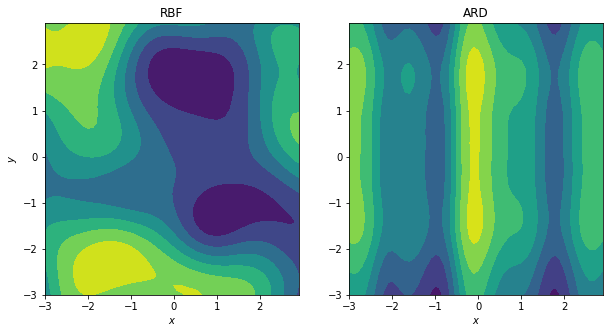

In [28]:
pl.figure(figsize=(10,5))
pl.subplot(121)
pl.contourf(x2d,y2d,s1)
pl.xlim(x.min(),x.max())
pl.ylim(y.min(),y.max())
pl.xlabel(r'$x$')
pl.ylabel(r'$y$')
pl.title('RBF')
pl.subplot(122)
pl.contourf(x2d,y2d,s2)
pl.xlim(x.min(),x.max())
pl.ylim(y.min(),y.max())
pl.xlabel(r'$x$')
pl.title('ARD');

In [29]:
# Function to plot samples from kernel
def pltsamples3(par2=0.5,par3=0.5, kernel_shortname='SE'):
    x = np.r_[-5:5:201j]
    X = np.matrix([x]).T # scipy.spatial.distance expects matrices
    kernel = get_kernel(kernel_shortname)
    K = kernel(X,X,[0.0,0.0,par2,par3])
    fig=pl.figure(figsize=(10,4))
    ax1 = pl.subplot2grid((1,3), (0, 0), aspect='equal')
    pl.imshow(np.sqrt(K),interpolation='nearest',vmin=0,vmax=10)
    pl.title('Covariance matrix')
    ax2 = pl.subplot2grid((1,3), (0,1),colspan=2)
    np.random.seed(0)
    for i in range(5):
        y = np.random.multivariate_normal(np.zeros(len(x)),K)
        pl.plot(x,y)
    pl.xlim(-5,5)
    pl.ylim(-5,5)
    pl.xlabel('x')
    pl.ylabel('y')
    pl.title('Samples from %s prior' % kernel_shortname)
    pl.tight_layout()
interact(pltsamples3, 
         par2=widgets.FloatSlider(min=1,max=3,step=1,description=r'$P$',value=2),
         par3=widgets.FloatSlider(min=-2,max=0,step=1,description=r'$\log_{10}\Gamma_2$',value=-1.),
         kernel_shortname=widgets.RadioButtons(options=['Per','QP'], value='Per',description='kernel')
        );

A Jupyter Widget